In [1]:
import pandas as pd
from pybedtools import BedTool
import os
from functools import reduce
# constant, data
# os.chdir("/Users/antata/Library/CloudStorage/OneDrive-BaylorCollegeofMedicine/text-mining/humanData/database/")

In [45]:
# preprocess MSA file
df = pd.read_csv("MSA.hg38.manifest.tsv", sep="\t")
df = df[["CpG_chrm", "CpG_beg", "CpG_end", "Probe_ID"]]
df.dropna(inplace=True)
df["CpG_beg"] = df["CpG_beg"].astype(int)
df["CpG_end"] = df["CpG_end"].astype(int)
df = df[~df["CpG_chrm"].isin(["chrY", "chrX", "chrM"])]
df.to_csv("MSA.hg38.txt", index=0, sep="\t", header=0)

In [224]:
# get ess/siv bed
import numpy as np
ess = pd.read_excel("ESS-2017.xlsx", sheet_name="Table S9")
ess["id"] = ess.apply(lambda x: f"SIV_{x['Chromosome']}_{x['Start']}_{x['Stop']}_{x['Genes']}" if str(x['Genes'])!="nan" else f"SIV_{x['Chromosome']}_{x['Start']}_{x['Stop']}_", axis=1)
ess["Start"] -= 1
ess = ess[["Chromosome", "Start", "Stop", "id"]]
ess
ess.to_csv("SIV.hg19.bed", sep="\t", header=0, index=0)

In [227]:
# get me bed
df = pd.read_csv("ME_qc.hg38.bed", sep="\t", names = ["chr", "start", "end", "id", "_", "__"])
df['coord'] = df['id'].apply(lambda x: x.split('_')[-1])
df[['chr', 'coord']] = df['coord'].str.split(":", expand=True)
df[['start', 'end']] = df['coord'].str.split("-", expand=True)
df["start"] = df["start"].astype(int)
df["end"] = df["end"].astype(int)
# df["id"] = df.apply(lambda x: f"ME_GB2015_{x['UCSC browser coordinates']}", axis=1)
df["start"] -= 1
df = df[["chr", "start", "end", "id"]]
df.to_csv("ME.hg19.bed", sep="\t", header=0, index=0)

In [235]:
# qc on ess, me, siv with chathura's results
siv_type ="ME"
df = pd.read_csv(f"{siv_type}.hg38.bed", sep="\t", names = ["chr", "start", "end", "id"])
qc = pd.read_csv(f"{siv_type}_qc.hg38.bed", sep="\t", names = ["chr", "start", "end", "id", "num", "strand"])
res = pd.merge(df, qc, on="id", how="outer", indicator=True)
print((res.shape[0] == df.shape[0]) and (res.shape[0] == qc.shape[0]) )
print(res[res['start_x']+1 != res['start_y']].to_string())
print(res[res['end_x'] != res['end_y']].to_string())
print(res[res['chr_x'] != res['chr_y']].to_string())

True
    chr_x   start_x     end_x                                id chr_y   start_y     end_y  num strand _merge
281  chr6  26758479  26758679  ME_GB2015_chr6:26743201-26743400  chr6  26758479  26758678    6      -   both
    chr_x   start_x     end_x                                id chr_y   start_y     end_y  num strand _merge
281  chr6  26758479  26758679  ME_GB2015_chr6:26743201-26743400  chr6  26758479  26758678    6      -   both
Empty DataFrame
Columns: [chr_x, start_x, end_x, id, chr_y, start_y, end_y, num, strand, _merge]
Index: []


In [268]:
epic = pd.read_csv("EPIC.hg38.txt", sep="\t", names=["chr", "start", "end", "id"]) 
hm450 = pd.read_csv("HM450.hg38.txt", sep="\t", names=["chr", "start", "end", "id"])
msa = pd.read_csv("MSA.hg38.txt", sep="\t", names=["chr", "start", "end", "id"])
# build union of all
probe_df = [hm450, epic, msa]
for d in probe_df:
    d.drop_duplicates(subset=["chr", "start", "end"], inplace=True)
probe = reduce(lambda  left,right: pd.merge(left,right,on=['chr', 'start', 'end'], how='outer'), probe_df)
probe.sort_values(by=["chr", "start"], inplace=True)
temp = BedTool.from_dataframe(probe[["chr", "start", "end"]])
temp = temp.merge(d=-1)
temp = temp.intersect(temp, wa=True, c=True)
res = temp.to_dataframe(names=["chr", "start", "end","count"])
res[["chr", "start", "end"]].to_csv("epic_hm450_msa_union.txt", sep="\t", header=0, index=0)
# union of hm450 and epic
hm450_epic = pd.merge(hm450,epic,on=['chr', 'start', 'end'], how='outer')
hm450_epic.sort_values(by=["chr", "start"], inplace=True)
temp = BedTool.from_dataframe(hm450_epic[["chr", "start", "end"]])
temp = temp.merge(d=-1)
temp = temp.intersect(temp, wa=True, c=True)
res = temp.to_dataframe(names=["chr", "start", "end","count"])
res[["chr", "start", "end"]].to_csv("epic_hm450.txt", sep="\t", header=0, index=0)
# df1 = res[res["count"]>1]

Empty DataFrame
Columns: [chr, start, end, count]
Index: []


In [302]:
corsiv = pd.read_csv("../corsiv2019.txt", sep="\t", names=["chr", "start", "end", "id"])
siv = pd.read_csv("SIV.hg38.bed", sep="\t", names=["chr", "start", "end", "id"])
ess = pd.read_csv("ESS.hg38.bed", sep="\t", names=["chr", "start", "end", "id"])
me = pd.read_csv("ME.hg38.bed", sep="\t", names=["chr", "start", "end", "id"])
# merge all regions
regions = [corsiv, siv, ess, me]
df = pd.concat(regions, axis=0).reset_index(drop=True)
df.sort_values(by=["chr", "start"], inplace=True)
temp = BedTool.from_dataframe(df[["chr", "start", "end"]])
temp = temp.merge(d=-1)
res = temp.to_dataframe(names=["chr", "start", "end"])
res.to_csv("all_regions.bed", sep="\t", header=0, index=0)
# merge all siv
regions = [siv, me]
df = pd.concat(regions, axis=0).reset_index(drop=True)
df.sort_values(by=["chr", "start"], inplace=True)
temp = BedTool.from_dataframe(df[["chr", "start", "end"]])
temp = temp.merge(d=-1)
res = temp.to_dataframe(names=["chr", "start", "end"])
res.to_csv("siv_all.bed", sep="\t", header=0, index=0)

In [5]:
epic = pd.read_csv("data/illumina/EPIC.hg38.txt", sep="\t", names=["chr", "start", "end", "id"]) 
hm450 = pd.read_csv("data/illumina/HM450.hg38.txt", sep="\t", names=["chr", "start", "end", "id"])
msa = pd.read_csv("data/illumina/MSA.hg38.txt", sep="\t", names=["chr", "start", "end", "id"])
all_probes = pd.read_csv("data/illumina/epic_hm450_msa_union.txt", sep="\t", names=["chr", "start", "end"]) # union of three
epic_hm450 = pd.read_csv("data/illumina/epic_hm450.txt", sep="\t", names=["chr", "start", "end"]) # union of three

corsiv = pd.read_csv("data/SIV regions/corsiv2019.txt", sep="\t", names=["chr", "start", "end", "id"])
siv = pd.read_csv("data/SIV regions/siv_all.bed", sep="\t", names=["chr", "start", "end", "id"])
ess = pd.read_csv("data/SIV regions/ESS.hg38.bed", sep="\t", names=["chr", "start", "end", "id"])
union_region = pd.read_csv("data/SIV regions/all_regions.bed", sep="\t", names=["chr", "start", "end"])

In [24]:
union_region["size"] = union_region["end"] - union_region["start"]
union_region["size"].idxmin()
# union_region[union_region["start"] == 10100]

3930

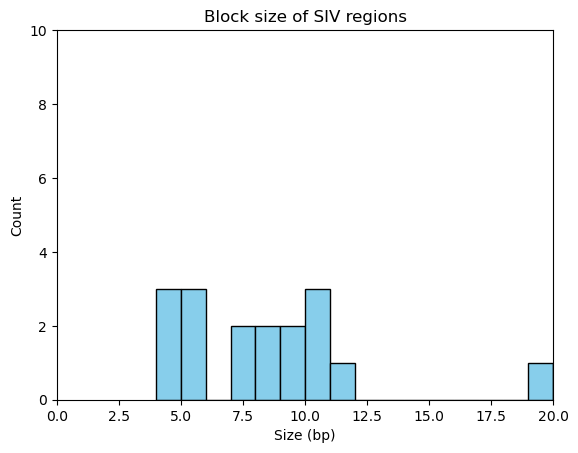

In [34]:
import matplotlib.pyplot as plt
import numpy as np
min_size = union_region["size"].min()
max_size = union_region["size"].max()

# Define the bins
bins = np.arange(min_size, max_size + 1, 1) 

# Assuming union_region is your DataFrame
plt.hist(union_region["size"], bins=bins, color='skyblue', edgecolor='black')
plt.xlabel('Size (bp)')
plt.ylabel('Count')
plt.title('Block size of SIV regions')
plt.xlim((0, 20))
plt.ylim((0, 10))

plt.show()

In [367]:
def get_overlap(probe_df, region_df):
    probe_df = probe_df.drop_duplicates(subset=["chr", "start", "end"])[["chr", "start", "end"]]
    probe_bed = BedTool.from_dataframe(probe_df)
    region_bed = BedTool.from_dataframe(region_df)
    res_bed = region_bed.intersect(probe_bed, wa=True, c=True)
    res = res_bed.to_dataframe(names=["chr", "start", "end", "id", "num"])
    return res["num"].sum(), res[res["num"]>0].shape[0]  #number of probes, number of regions covered

probe_df = [[],[],[],[],[]]
region_df= [[],[],[],[],[]]
plabel =[ "hm450", "epic", "msa", "epic-hm450", "Union"]
rlabel = ["corsiv", "ess", "siv", "union"]
for i, r in enumerate([corsiv, ess, siv, union_region]):
    for j, p in enumerate([hm450, epic, msa, epic_hm450, all_probes]):
        pcount, rcount = get_overlap(p, r)
        probe_df[j].append(pcount)
        region_df[j].append(rcount)
probe_df = pd.DataFrame(probe_df, index=plabel, columns=rlabel)
region_df = pd.DataFrame(region_df, index=plabel, columns=rlabel)

print(probe_df)
print(region_df)

            corsiv  ess  siv  union
hm450         1701  660  698   2546
epic          2397  645  699   3221
msa           3291  551  503   3774
epic-hm450    2512  696  760   3412
Union         4162  794  844   5121
            corsiv  ess  siv  union
hm450          837  198  224   1102
epic          1306  198  230   1574
msa           1428  167  178   1615
epic-hm450    1335  198  234   1607
Union         1861  198  244   2133
